# Bayesian Structural Time Series Model

In [2]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
sns.set(rc={'figure.figsize': (12,8)})

In [6]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv('data/datasetRofex2.csv',
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

## Model

In [15]:
tf.reset_default_graph()

trend = sts.LocalLinearTrend(observed_time_series=df['Cierre'])
seasonal = tfp.sts.Seasonal(num_seasons=33,
                            num_steps_per_season=123,
                            observed_time_series=df['Cierre'])
model = sts.Sum([trend, seasonal], observed_time_series=df['Cierre'])

with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
    elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
        model, observed_time_series=df['Cierre'])

In [16]:
# Minimize the variational loss.

steps = 300

train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        _, elbo_ = sess.run((train_vi, elbo_loss))
        if i % 20 == 0:
            print("step {} -ELBO {}".format(i, elbo_))

        samples = sess.run({k: q.sample(50)
                                    for k, q in variational_posteriors.items()})

Instructions for updating:
Use tf.cast instead.
step 0 -ELBO 13898.426508153976
step 20 -ELBO 11096.019772433687
step 40 -ELBO 11049.409100971687
step 60 -ELBO 10955.25348163548
step 80 -ELBO 10888.07025957051
step 100 -ELBO 10830.207247427343
step 120 -ELBO 10800.165052282453
step 140 -ELBO 10779.162765830239
step 160 -ELBO 10757.692945109377
step 180 -ELBO 10749.661086729133
step 200 -ELBO 10739.044708935604
step 220 -ELBO 10737.217618911487
step 240 -ELBO 10731.944961774681
step 260 -ELBO 10725.955291511376
step 280 -ELBO 10727.224423637928


In [18]:
for param in model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(samples[param.name], axis=0),
                                np.std(samples[param.name], axis=0)))

observation_noise_scale: 0.5567902470113625 +- 0.05114081665601736
LocalLinearTrend/_level_scale: 3.7259049027030837 +- 0.050239489706640626
LocalLinearTrend/_slope_scale: 0.04248401394606474 +- 0.022135256083132934
Seasonal/_drift_scale: 1.0614566628941073 +- 1.641638173945495


In [19]:
price_dist = tfp.sts.forecast(model,
                              observed_time_series=df['Cierre'],
                              parameter_samples=samples,
                              num_steps_forecast=steps)

In [23]:
num_samples = 10

with tf.Session() as sess:
    price_mean, price_scale, price_forecast_samples = sess.run(
        (price_dist.mean()[..., 0], price_dist.stddev()[..., 0],
         price_dist.sample(num_samples)[..., 0]))

Instructions for updating:
Use tf.random.categorical instead.


In [46]:
last_day = df.index[-1]
forecast_period = pd.date_range(start=last_day + pd.DateOffset(1), periods=steps, freq='B')

In [60]:
forecasts = pd.DataFrame({'forecast': price_mean}, index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

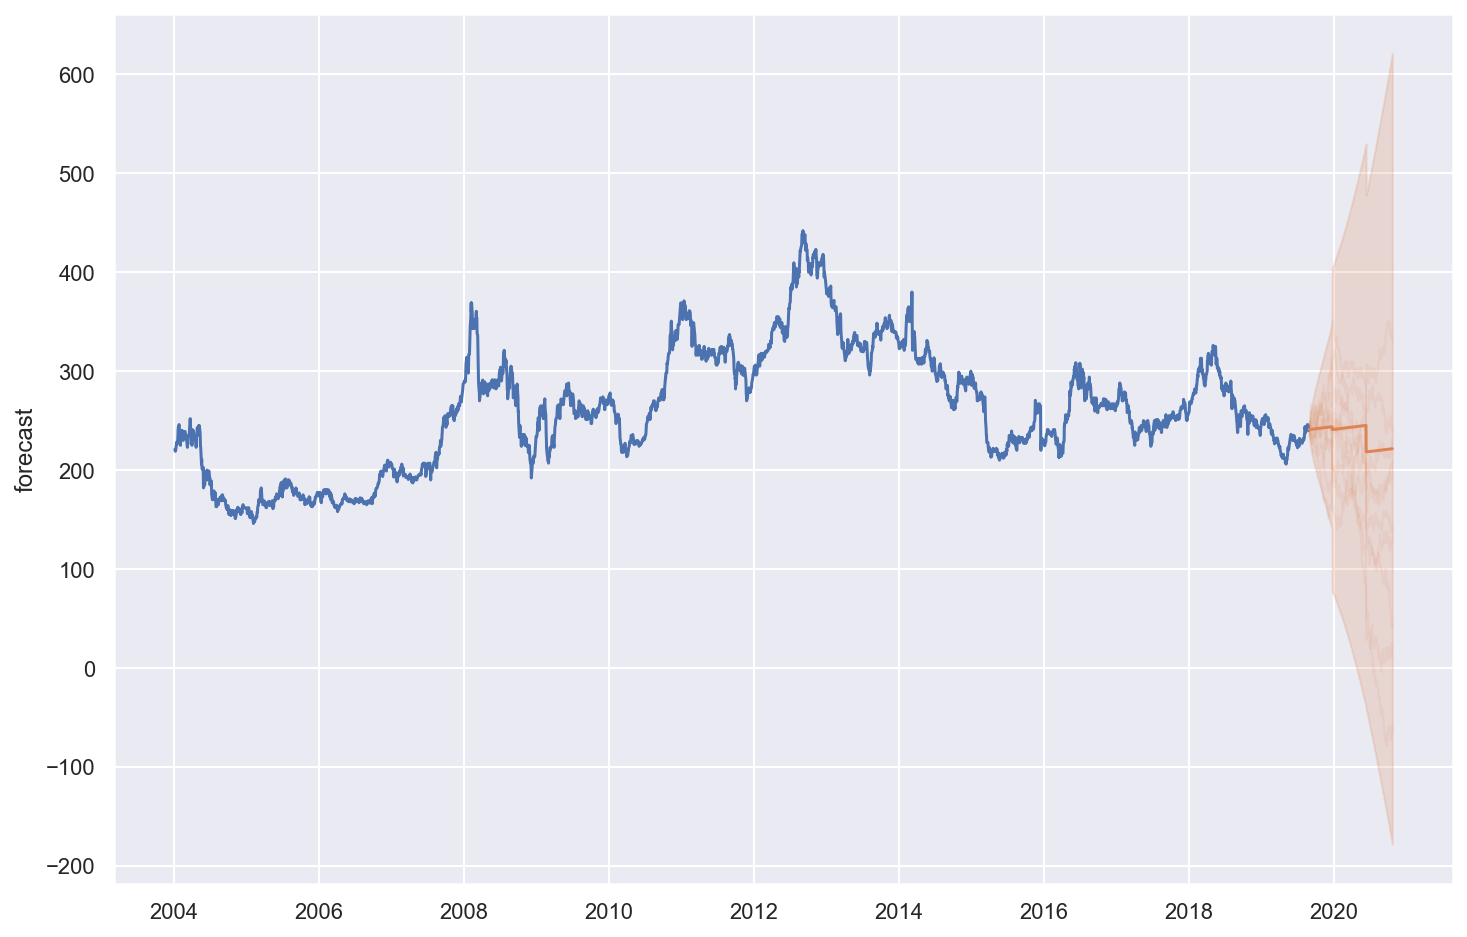

In [74]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

ax = sns.lineplot(x=forecast_df.index, y=forecast_df['Cierre'])
sns.lineplot(x=forecast_df.index, y=forecast_df['forecast'], ax=ax)
ax.plot(forecast_period, price_forecast_samples.T, lw=1, color=c2, alpha=0.1);
ax.fill_between(forecast_period,
                price_mean - 2 * price_scale,
                price_mean + 2 * price_scale,
                color=c2,
                alpha=0.2);